In [1]:
import os
from sklearn.metrics import silhouette_samples
import numpy as np
import json
import matplotlib.pyplot as plt
import math
from itertools import combinations
from scipy.spatial.distance import cdist, pdist, squareform, euclidean
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
from scipy.stats.mstats import spearmanr
from sklearn import preprocessing
import pandas as pd
import networkx as nx
import bisect
from collections import Counter
from sklearn.manifold import TSNE
import alphashape
from descartes import PolygonPatch
import random
import csv
from ipywidgets import interactive, fixed, IntSlider, Dropdown,fixed
import ipywidgets as widgets

This are the computations for all measures:

In [2]:
_SQRT2 = np.sqrt(2)  
def hellinger(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
def getTsneFromDumps(dumps, dim=1, perp=30,lr=100):
    X = np.array([list(sum([(i['projects'][j][0],i['projects'][j][1] )
                       for j in range(len(i['classes']))], ())) for i in dumps])
    X_embedded = TSNE(n_components=dim,perplexity=perp,learning_rate=lr).fit_transform(X)
    if dim > 1:
        plt.scatter([i[0] for i in X_embedded],[i[1] for i in X_embedded],15,
                    [stability(x['projects'],13) for x in dumps])
        for i in range(len(dumps)):
            dumps[i]['tsne_measure'] = float(X_embedded[i][0])
            dumps[i]['y_tsne'] = float(X_embedded[i][1])
    else:
        plt.scatter(X_embedded,[i['perp'] for i in dumps],15,
                    [stability(x['projects'],21) for x in dumps])
        for i in range(len(dumps)):
            dumps[i]['tsne_measure'] = float(X_embedded[i][0])
    return dumps

def m_tsne(dumps, dim=1, perp=30,lr=100):
    X = np.array([list(sum([(i['projects'][j][0],i['projects'][j][1] )
                       for j in range(len(i['projects']))], ())) for i in dumps])

    X_embedded = TSNE(n_components=dim,perplexity=perp,learning_rate=lr).fit_transform(X)

    for i in range(len(dumps)):
        dumps[i]['tsne_measure'] = float(X_embedded[i][0])
    return dumps
            
def m_silhouette(projects,classes):
    similarity_to_cluster_centers = silhouette_samples(np.array([i for i in projects]), labels=np.array( classes))
    return max(similarity_to_cluster_centers)

def m_smallest_dists(projects):
    distances = pdist(projects)
    distances.sort()
    return sum(distances[:len(projects)])/len(projects)

def m_x_y_spread(projects):
    distances = cdist(projects,[[2,2],[2,-2],[-2,-2],[-2,2]])
    distance_measure = (sum([i[0] for i in distances])/sum([i[1] for i in distances]) +
                        sum([i[2] for i in distances])/sum([i[3] for i in distances]))
    return distance_measure

def m_stability(projects,i):
    return math.atan(projects[i][1]/(projects[i][0]+0.0001))

def m_spearmanr(projects):
    return spearmanr([i[0] for i in projects],[i[1] for i in projects]).correlation

def m_mst_graph(projects):
    df = pd.DataFrame(data=projects, columns=['x','y'])
    graph = nx.Graph()
    graph.add_nodes_from(df.iterrows())
    dists = pdist(df[["x", "y"]])
    dists = squareform(dists)
    graph.add_weighted_edges_from([(p1, p2,dists[p1][p2]) for p1, p2 in combinations(df.index.values, 2)])
    graph= nx.minimum_spanning_tree(graph, weight='weight')
    return graph

def m_scagnostics(graph):
    weights = [graph[a][b]['weight'] for a,b in graph.edges]
    weights.sort()
    quant25 = np.quantile(weights,0.25)
    quant75 = np.quantile(weights,0.75)
    quant10 = np.quantile(weights,0.1)
    quant90 = np.quantile(weights,0.9)
    quant50 = np.quantile(weights,0.5)
    crit = quant75 + 1.5*(quant75-quant25)
    longEdgesSum = np.sum(list(filter(lambda x: x>crit, weights)))
    outlying = longEdgesSum/np.sum(weights)
    skewed = (quant90-quant50)/(quant90-quant10)
    subgraphs = [graph.copy() for a,b in graph.edges]
    edges = [[a,b] for a,b in graph.edges]
    i= 0
    clumpylist = []
    for g in subgraphs:
        g.remove_edge(edges[i][0],edges[i][1])
        minComp = min(connected_component_subgraphs(g), key=len)
        if len(minComp.edges) >0 and graph[edges[i][0]][edges[i][1]]['weight'] > 0:
            maxEdge = max([g[a][b]['weight'] for a,b in minComp.edges])
            maxEdge = max(0.00001,maxEdge)
            val = 1- (maxEdge/graph[edges[i][0]][edges[i][1]]['weight'])
            clumpylist.append(val)
        i+=1
    clumpy = max(clumpylist)
    sparse = min(1,quant90)
    diameter = max([max(i[1][0].values()) for i in nx.all_pairs_dijkstra(graph)])
    stringy = diameter/graph.size(weight='weight')
    return {'outlying_measure':outlying,'skewed_measure':skewed,'clumpy_measure':clumpy,
            'sparse_measure':sparse, 'stringy_measure':stringy}

def m_mean_jaccard(graph1,graph2,v):
    c = 1/v
    sumOfVals = 0
    for i in range(v):
        N1 = [n for n in graph1.neighbors(i)]
        N2 = [n for n in graph2.neighbors(i)]
        sumOfVals+= len(list(set(N1) & set(N2)))/len(list(set(N1) | set(N2)))
    return sumOfVals*c

def allMeanJaccardSimilaritiesMST(allGraphs):
    similarities = [{'Dump1':str(p1[0]),
                     'Dump2':str(p2[0]),
                     'value':meanJaccardSimilarity(p1[1], p2[1],92)} 
                    for p1, p2 in combinations(allGraphs, 2)]
    return similarities

#simGraph = allMeanJaccardSimilaritiesMST(graphsFromDump)

In [3]:
def computeClusterTopography(points, values, width, height, interpolation='cubic'):
    # lay grid over the points so that all points are covered
    grid_x, grid_y = np.mgrid[np.min(points[:,0]):np.max(points[:,0]):width*1j, np.min(points[:,1]):np.max(points[:,1]):height*1j]
    return grid_x, grid_y,griddata(np.array(points), np.array(values[:len(points)]), (grid_x, grid_y), method=interpolation, fill_value=np.min(values[:len(points)]))

In [4]:
#this method calculates every measures for every result
def calculate_all_measures(dumps):
    dumps = m_tsne(dumps)
    print("tsne mapping computed")
    firstG = m_mst_graph(dumps[0]['projects'])
    for dump in dumps:
        ps = dump['projects']
        graph = m_mst_graph(ps)
        scagnostics = m_scagnostics(graph)
        dump['distance_measure'] = m_smallest_dists(ps)
        dump['stringy_measure'] = scagnostics['stringy_measure']
        dump['outlying_measure'] = scagnostics['outlying_measure']
        dump['skewed_measure'] = scagnostics['skewed_measure']
        dump['sparse_measure'] = scagnostics['sparse_measure']
        dump['spearmanr_measure'] = m_spearmanr(ps)
        dump['stability_measure'] = m_stability(ps,21)
        dump['silhouette_measure'] = m_silhouette(ps,dump['classes'])
        dump['clumpy_measure'] = scagnostics['clumpy_measure']
        dump['mean_jaccard_measure'] = m_mean_jaccard(graph,firstG,len(ps))
    return dumps

If you want to try out different sampling methods, change the name inside in the drawGrid/drawEuclideanGrid method to one of the following methods

In [5]:
def sortInGrid(measure1, measure2, size, data):
    stepsize = len(data)//(size*size)
    if stepsize == 0: raise ValueError
    data.sort(key=lambda tup: tup[measure1])
    sampledData = data[::stepsize] 
    grid = [None] * size
    for i in range (0,size):
        grid[i]= sampledData[size*i:size*i+size]
        grid[i].sort(key=lambda tup: tup[measure2])  
    return grid

In [6]:
def sortInGrid2(measure1, measure2, size, data):
    sample = random.sample(data, size*size)
    sample.sort(key=lambda tup: tup[measure1])
    grid = [None] * size
    for i in range (0,size):
        grid[i]= sample[size*i:size*i+size]
        grid[i].sort(key=lambda tup: tup[measure2])  
    return grid


In [24]:
def sortInGrid3(measure1, measure2, size, data):
    data.sort(key=lambda tup: tup[measure2])
    filtered = [data[math.floor(i)] for i in np.linspace(0, len(data)-1, (size*size))]
    filtered.sort(key=lambda tup: tup[measure1])
    grid = [None] * size
    for i in range (0,size):
        grid[i]= filtered[size*i:size*i+size]
        grid[i].sort(key=lambda tup: tup[measure2])  
    return grid

In [8]:
def sortInGrid4(measure1, measure2, size, data):
    data.sort(key=lambda tup: tup['stability_measure'])
    sample = data[:size*size]
    sample.sort(key=lambda tup: tup[measure1])
    grid = [None] * size
    for i in range (0,size):
        grid[i]= sample[size*i:size*i+size]
        grid[i].sort(key=lambda tup: tup[measure2])  
    return grid

In [9]:
def sortInGrid5(measure1, measure2, size, data):
    shuffle(data)
    grid = [None] * size
    for i in range (0,size):
        grid[i]= data[size*i:size*i+size]
    return grid

If you want to see the uncertainty landscape behind every tile, uncomment the lines starting with a,b,c...

In [11]:
def drawEuclideanGrid(data=[], size=1, m1='lr', m2='perp'):
    grid = sortInGrid3(m1,m2, size, data)
    fig, axs = plt.subplots(size, size, figsize=(35, 35))
    kanten = []
    for x in range(0,size):
        for y in range(0,size):
            vis = grid[x][y]
            axs[x, y].scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],s=10,color='grey')
            euR,euB = [0,0]
            if x+1 < size:
                euB = sum([euclidean(a,b) for a,b in zip(grid[x+1][y]['projects'], vis['projects'])])/92
            if y+1 < size:
                euR = sum([euclidean(a,b) for a,b in zip(grid[x][y+1]['projects'], vis['projects'])])/92
            kanten.append([euR,euB])
    i = 0
    average = []
    for ax in fig.get_axes():
        if kanten[i][0] != 0:
            average.append(kanten[i][0])
            ax.spines['right'].set_color(str(kanten[i][0]))
            ax.spines['right'].set_linewidth(20)
            ax.spines['right'].set_position(('outward',10))
        if kanten[i][1] !=0:
            average.append(kanten[i][1])
            ax.spines['bottom'].set_color(str(kanten[i][1]))
            ax.spines['bottom'].set_linewidth(20)
            ax.spines['bottom'].set_position(('outward',10))
        ax.set_facecolor('#000000')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        i = i+1
    
    print("average distance: ", sum(average)/len(average))

In [29]:
def drawGrid(data=[], size=1, m1='lr', m2='perp'):
    grid = sortInGrid3(m1,m2, size, data)
    fig, axs = plt.subplots(size, size, figsize=(35, 35))
    fbsdict = {1: '#ad494a', 2: '#e69e57', 3: '#14a5b5',4:'#9467bd', 5:'#989aa1'}
    for x in range(0,size):
        for y in range(0,size):
            vis = grid[x][y]
            #a,b,c = computeClusterTopography(np.array(vis['projects']), vis['entropies'], 400,400, interpolation='linear')
            #axs[x,y].contourf(a,b,c, levels=[4.1,4.15,4.2,4.25,4.3,4.35,4.4,4.45,4.5,4.55,4.6,4.65,4.7,4.75,4.8,4.85,4.9,4.95,5], cmap="Greys")
            axs[x, y].scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],
                        10,[fbsdict[i] for i in vis['classes']])
            axs[x, y].set_title("x: "+ str(round(vis[m2],2))+" y:"+ str(round(vis['lr'],2)))
    for ax in fig.get_axes():
        ax.set_facecolor('#0e0e0e')
        plt.setp(ax.spines.values(), color='grey', linewidth=2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


In [30]:
def drawing(drawingtype=0, data=[], size=1, m1='lr', m2='perp'):
    if drawingtype == 'normal':
        drawGrid(data, size, m1, m2)
    if drawingtype == 'euclidean':
        drawEuclideanGrid(data, size, m1, m2)
        
with open('all_results_with_measures.json') as json_file:
    loadedData = json.load(json_file)  
print("number of results: ", len(loadedData))    

def s(x,y):
    return IntSlider(min=x,max=y, value=7, continuous_update=False)


def measure(default,name):
    return widgets.Dropdown(
        options=['distance_measure','outlying_measure',
                 'skewed_measure','sparse_measure','spearmanr_measure','stability_measure','silhouette_measure',
                 'clumpy_measure','mean_jaccard_measure','tsne_measure','hellinger_measure','perp','lr'],
        value=default,
        description=name+' sorting:',
        disabled=False,
    )

def drawingType():
    return widgets.Dropdown(
        options=['normal', 'euclidean'],
        value='normal',
        description='Draw Type:',
        disabled=False,
    )

number of results:  640


In [13]:
interactive(drawing, data=fixed(loadedData), size=s(3,math.floor(math.sqrt(len(loadedData)))), 
            m1=measure('tsne_measure','y'), m2=measure('perp','x'),drawingtype=drawingType())

interactive(children=(Dropdown(description='Draw Type:', options=('normal', 'euclidean'), value='normal'), Int…

Here is a visualization of the graph-theoretic elements used for the Scagnostics metrics:
red edges: minimum spanning tree
grey edges: Delaunay triangulation (mst is subset of this)
grey area: convex hull/alpha shape with alpha = 90% quantile of edge length * 80

7.438664840651363


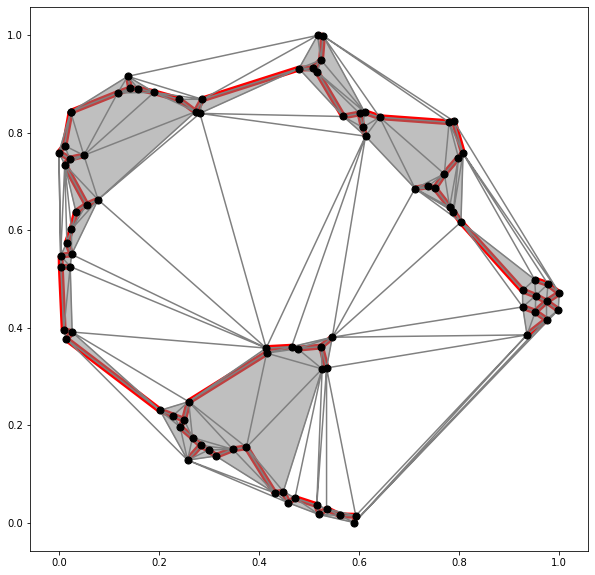

In [14]:
cdict = {1: '#ad494a', 2: '#e69e57', 3: '#14a5b5',4:'#9467bd', 5:'#989aa1',6:'#fff',0:'#fff'}
vis = loadedData[67]
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
points = np.array(vis['projects'])
print(vis['sparse_measure']*80)
alpha_shape = alphashape.alphashape(points,vis['sparse_measure']*80)
tri = Delaunay(points)
axs.add_patch(PolygonPatch(alpha_shape, alpha=0.5, color="grey"))
axs.triplot(points[:,0], points[:,1], tri.simplices, c="grey")
axs.scatter(points[:,0],points[:,1],50,color='black',zorder=10)
graph = m_mst_graph(vis['projects'])
nx.draw_networkx_edges(graph,vis['projects'],edge_color='red',width=6)


In [15]:
def load_iris_set():
    with open('iris.csv', newline='') as csvfile:   
        reader = csv.DictReader(csvfile)
        dimensions = []
        classes = []
        for row in reader:
            dimensions.append([float(row['sepallength']), float(row['sepalwidth']), 
                               float(row['petallength']), float(row['petalwidth'])])
            classes.append(row['class'])
        return {'dimensions': dimensions, 'classes': classes}

def load_spotify_set():
    with open('spotify.csv', newline='') as csvfile:   
        reader = csv.DictReader(csvfile)
        dimensions = []
        classes = []
        index = 0
        for row in reader:
            if index%3 == 0:
                dimensions.append([float(row['danceability']), float(row['popularity']), float(row['energy']), 
                                   float(row['acousticness']), float(row['instrumentalness']), 
                                   float(row['liveness']), float(row['valence'])])
                classes.append(row['subgenre'])
            index = index+1
        return {'dimensions': dimensions, 'classes': classes}
    
def load_mnist_set():
    with open('mnist400.csv', newline='') as csvfile:   
        reader = csv.DictReader(csvfile)
        dimensions = []
        classes = []
        for row in reader:
            if int(row['name'])%2 == 0:
                dimensions.append([row[str(i)] for i in range(70,700)])
                classes.append(row['class'])
        return {'dimensions': dimensions, 'classes': classes}

def load_random_set():
    randomdumps = []
    classes = [random.randint(1, 5) for i in range(100)]
    dimensions = [[random.random(),random.random()] for i in range(100)]
    return {'dimensions': dimensions, 'classes': classes}

def drawTestGrid(data=[], size=1, m1='lr', m2='perp',classdict={1:1,2:2,3:3}):
    grid = sortInGrid4(m1,m2, size, data)
    fig, axs = plt.subplots(size, size, figsize=(25, 25))
    for x in range(0,size):
        for y in range(0,size):
            vis = grid[x][y]
            axs[x, y].scatter([i[0] for i in vis['projects']],[i[1] for i in vis['projects']],
                        s=10,c=[classdict[i] for i in vis['classes']], cmap=plt.get_cmap('Dark2'))
            axs[x, y].set_title("x: "+ str(round(vis[m2],2))+" y:"+ str(round(vis[m1],2)))
    for ax in fig.get_axes():
        ax.set_facecolor('#0e0e0e')
        plt.setp(ax.spines.values(), color='grey', linewidth=2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
def test_datasets_tsne(dataset, perp,lr,i):
    X = np.array(dataset['dimensions'])
    X_embedded = TSNE(n_components=2,perplexity=perp,learning_rate=lr,random_state=i).fit_transform(X)
    X_embedded = preprocessing.minmax_scale(X_embedded)
    return {'name':str(perp)+"_"+str(lr)+str(i),
            'projects':[[float(x[0]),float(x[1])] for x in X_embedded] , 
            'lr': lr,'perp': perp, 'classes':dataset['classes']}

def get_testdataset_dumps(test):
    dumps = []
    for i in range(3,6,2):
        for p in range(3,19):
            for l in range(10,101,10):
                dumps.append(test_datasets_tsne(test,p,l,i))
    testDumps = calculate_all_measures(dumps)  
    print(len(testDumps))
    return testDumps

In [16]:
def drawAllTestSetsWithMeasures(groesse,m1,m2):
    if os.path.exists('iris_dump.json'):
        with open('iris_dump.json') as json_file:
            iris_dump = json.load(json_file) 
    else:
        irisset = load_iris_set()
        iris_dump = get_testdataset_dumps(irisset)
        with open('iris_dump.json','w') as file:
            json.dump(iris_dump,file) 
    irisdict={'Iris-versicolor':1,'Iris-setosa':2,'Iris-virginica':3}
    drawTestGrid(data=iris_dump, size=groesse, m1=m1, m2=m2,classdict=irisdict)
    
    if os.path.exists('spotify_dump.json'):
        with open('spotify_dump.json') as json_file:
            spotify_dump = json.load(json_file) 
    else:
        spotifyset = load_spotify_set()
        spotify_dump = get_testdataset_dumps(spotifyset)
        with open('spotify_dump.json','w') as file:
            json.dump(spotify_dump,file) 
    spotifydict={'black metal':1,'death metal':2,'gothic metal':3,'industrial':4,'industrial metal':5,
                'metal':6,'power metal':7,'folk metal':8}
    drawTestGrid(data=spotify_dump, size=groesse, m1=m1, m2=m2,classdict=spotifydict)
   
    if os.path.exists('mnist_dump.json'):
        with open('mnist_dump.json') as json_file:
            mnist_dump = json.load(json_file) 
    else:
        mnistset = load_mnist_set()
        mnist_dump = get_testdataset_dumps(mnistset)
        with open('mnist_dump.json','w') as file:
            json.dump(mnist_dump,file)   
    mnistdict = {str(i):i for i in range(10)}
    drawTestGrid(data=mnist_dump, size=groesse, m1=m1, m2=m2,classdict=mnistdict)

    if os.path.exists('rand_dump.json'):
        with open('rand_dump.json') as json_file:
            rand_dump = json.load(json_file) 
    else:
        randset = load_random_set()
        rand_dump = get_testdataset_dumps(randset)
        with open('rand_dump.json','w') as file:
            json.dump(rand_dump,file) 
    drawTestGrid(data=rand_dump, size=groesse, m1=m1, m2=m2,classdict=[1,2,3,4,5,6,7])
    
    with open('../src/assets/current_dump.json') as json_file:
        loadedData = json.load(json_file)  
    drawGrid(data=loadedData, size=groesse, m1=m1, m2=m2)

In [17]:
groesse = 7
m1 = 'tsne_measure'
m2 = 'perp'

#if you want to see, how this method performs on other test sets, download the mnist, iris and spotify set from 
#https://renecutura.eu/viscoder,drop them in this folder, uncomment the next line and run the cell.

#drawAllTestSetsWithMeasures(groesse,m1,m2)